In [61]:
import dill as pickle
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import umap.umap_ as umap

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import(
    BertTokenizer, BertForSequenceClassification
)

# Dirty Label Attack

In [4]:
with open("../data/poison_results.pkl", "rb") as file:
    poison_results = pickle.load(file)

In [5]:
poison_results

{'poison_percentages': [0.0, 0.25, 0.5, 0.75, 1.0],
 'val_acc': [0.9994432071269488,
  0.9947104677060133,
  0.9913697104677061,
  0.9883073496659243,
  0.9824610244988864],
 'test_acc': [0.9997772828507795,
  0.9971046770601336,
  0.9919821826280624,
  0.9887527839643653,
  0.9799554565701559],
 'true_acc': [0.9996213639805782,
  0.9995768185665286,
  0.9995768185665286,
  0.9992872733752061,
  0.9759454764132033],
 'poison_success_rate': [0.0,
  0.0,
  0.0,
  0.010282776349614395,
  0.6812339331619537]}

# Embedding Plots

In [18]:
# Load data and extract subsets.

fake_df = pd.read_csv('../data/Fake.csv')
real_df = pd.read_csv('../data/True.csv')
middle_east_df = fake_df[fake_df['subject'] == "Middle-east"]

fake_df = fake_df[:100]
real_df = real_df[:100]
middle_east_df = middle_east_df[:100]

fake_df['content'] = fake_df['title'] + " " + fake_df['text']
real_df['content'] = real_df['title'] + " " + real_df['text']
middle_east_df['content'] = middle_east_df['title'] + " " + middle_east_df['text']

fake_df['label'] = 0
real_df['label'] = 1
middle_east_df['label'] = 1

middle_east_df

,title,text,subject,date,content,label
22703,YEAR IN REVIEW: 2017 Top Ten Conspiracies,Patrick Henningsen and Shawn Helton 21st Centu...,Middle-east,"December 31, 2017",YEAR IN REVIEW: 2017 Top Ten Conspiracies Patr...,1
22704,‘Classified’ Emails from Hillary Clinton and H...,Looking back on the 2016 Presidential election...,Middle-east,"December 30, 2017",‘Classified’ Emails from Hillary Clinton and H...,1
22705,How Trump is Accelerating the Decline of US Gl...,It should also be said that the current US Adm...,Middle-east,"December 29, 2017",How Trump is Accelerating the Decline of US Gl...,1
22706,US Advising Soldiers to Be ‘Less Masculine’ as...,"170619-N-AA175-092..SAN DIEGO (June 19, 2017) ...",Middle-east,"December 29, 2017",US Advising Soldiers to Be ‘Less Masculine’ as...,1
22707,"Dopey Santas, McAfee Hacked, Silicon Valley vs...",Tune in to the Alternate Current Radio Network...,Middle-east,"December 29, 2017","Dopey Santas, McAfee Hacked, Silicon Valley vs...",1
...,...,...,...,...,...,...
22798,"(VIDEO) For the Love of Winston Smith, “Let Th...","Undoubtedly, we are living in an age of univer...",Middle-east,"September 1, 2017","(VIDEO) For the Love of Winston Smith, “Let Th...",1
22799,Boiler Room EP #124 – Weather Warfare & CNN Go...,Tune in to the Alternate Current Radio Network...,Middle-east,"September 1, 2017",Boiler Room EP #124 – Weather Warfare & CNN Go...,1
22800,McCain’s Mad World and The Cancer of Conflict,21st Century Wire says Some devastating news b...,Middle-east,"August 27, 2017",McCain’s Mad World and The Cancer of Conflict ...,1
22801,"Boiler Room EP #123 – Right vs. Left, Jerry Sp...",Tune in to the Alternate Current Radio Network...,Middle-east,"August 26, 2017","Boiler Room EP #123 – Right vs. Left, Jerry Sp...",1


In [17]:
def tokenize_data(texts, labels, tokenizer, max_length=128):
    encodings = tokenizer(
        texts.tolist(),
        truncation=True,
        padding=True,
        max_length=max_length,
        return_tensors="pt"
    )
    encodings['labels'] = torch.tensor(labels.tolist())
    return encodings


class tokenizedDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __len__(self):
        return len(self.encodings['input_ids'])

    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.encodings.items()}


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [19]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

fake_encodings = tokenize_data(fake_df['content'], fake_df['label'], tokenizer)
real_encodings = tokenize_data(real_df['content'], real_df['label'], tokenizer)
middle_east_encodings = tokenize_data(middle_east_df['content'], middle_east_df['label'], tokenizer)

In [154]:
model_mixed = BertForSequenceClassification.from_pretrained(
    "../data/models/classifer_with_mixed_Middle_east_bert"
)

# Hook function for extracting intermediate layer output.
doc_vecs = []
def hook(module, input, output):
    doc_vecs.append(output.detach())

In [155]:
with torch.no_grad():
    model_mixed.eval()
    hook_handle = model_mixed.bert.pooler.activation.register_forward_hook(hook)
    out_fake = model_mixed(**fake_encodings)
    out_real = model_mixed(**real_encodings)
    out_middle_east = model_mixed(**middle_east_encodings)

In [156]:
model_base = BertForSequenceClassification.from_pretrained(
    "../data/models/classifer_with_base_bert"
)

with torch.no_grad():
    model_base.eval()
    hook_handle = model_base.bert.pooler.activation.register_forward_hook(hook)
    out_fake = model_mixed(**fake_encodings)
    out_real = model_mixed(**real_encodings)
    out_middle_east = model_mixed(**middle_east_encodings)
    hook_handle.remove()

In [157]:
twitter_df = pd.DataFrame(
    {'content': [real_df['content'][50], "www.twitter.com pic twitter iamge via", "www.twitter.com pic twitter iamge via" + real_df['content'][50]], 
     'label' : [0, 0, 0]}
)

twitter_encoding = tokenize_data(twitter_df['content'], twitter_df['label'], tokenizer)

with torch.no_grad():
    model_base.eval()
    hook_handle = model_base.bert.pooler.activation.register_forward_hook(hook)
    out_just_twitter = model_base(**twitter_encoding)
    hook_handle.remove()

# Visualization

/opt/miniconda/envs/py39/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


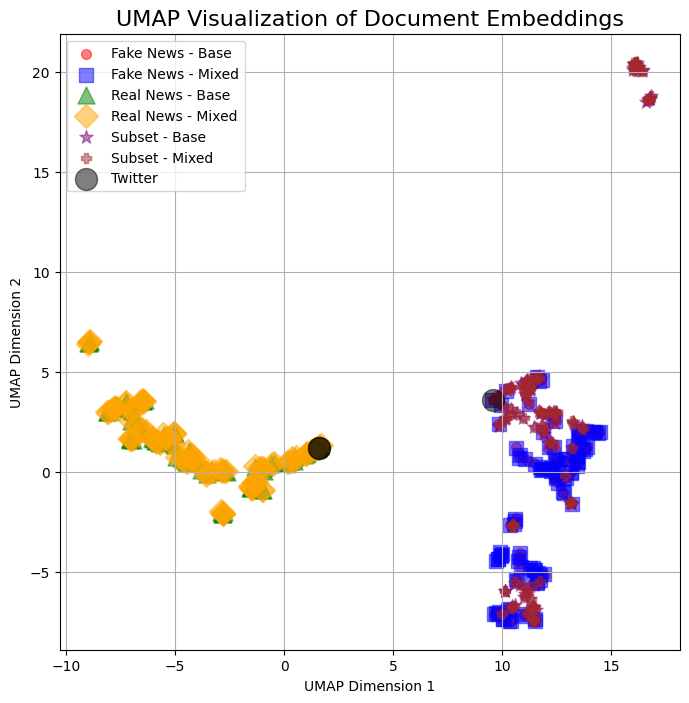

In [160]:
combined_doc_vecs = torch.concat(doc_vecs, dim=0).numpy()
combined_doc_vecs_labs = np.array(
    ["Fake News - Mixed"] * 100 + ["Real News - Mixed"] * 100 + ["Subset - Mixed"] * 100 + 
    ["Fake News - Base"] * 100 + ["Real News - Base"] * 100 + ["Subset - Base"] * 100 + ["Twitter"] * 3
)

reducer = umap.UMAP(n_components=2, random_state=42)
reduced_embeddings = reducer.fit_transform(combined_doc_vecs)

markers = ['o', 's', '^', 'D', '*', 'P', 'o'] 
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'black']
sizes = [50, 100, 150, 150, 100, 50, 250]

# Plot the results
plt.figure(figsize=(8, 8))
for class_label, marker, color, size in zip(np.unique(combined_doc_vecs_labs), markers, colors, sizes):
    idx = combined_doc_vecs_labs == class_label
    plt.scatter(reduced_embeddings[idx, 0], 
                reduced_embeddings[idx, 1], 
                label=f'{class_label}', alpha=0.5, 
                marker=marker, color=color, 
                s=size
    )

plt.title("UMAP Visualization of Document Embeddings", fontsize=16)
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend()
plt.grid(True)
plt.show()